# Convolutional Neural Net - Un esempio pratico

## Preparazione dei dati

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !unzip ./drive/MyDrive/Datasets/data.zip

## Libreria


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
tf.__version__

'2.7.0'

## Generate a `Dataset`


In [ ]:
image_size = (180, 180)
batch_size = 32

# tf.keras.preprocessing.image_dataset_from_directory()

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    labels='inferred', 
    label_mode='binary',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    # color_mode='grayscale'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/validation",
    labels='inferred', 
    label_mode='binary',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    # color_mode='grayscale'
)


Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 1000 files belonging to 2 classes.
Using 200 files for validation.


## Visualize data

0 = 'cat'
 
1 = 'dog'

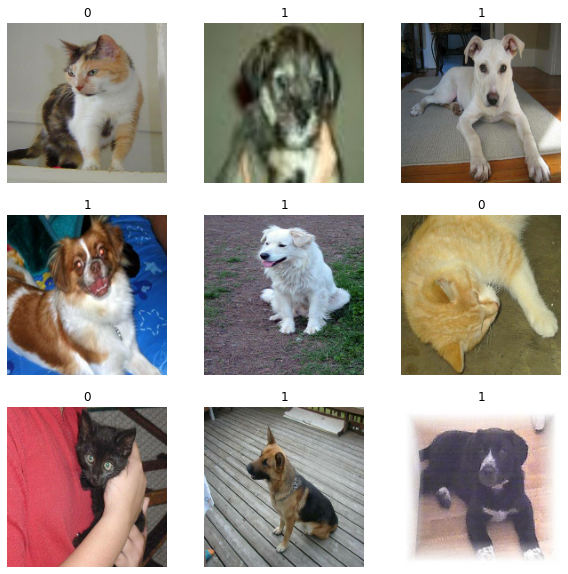

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Data augmentation


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.25)
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


tf.Tensor([1.], shape=(1,), dtype=float32)


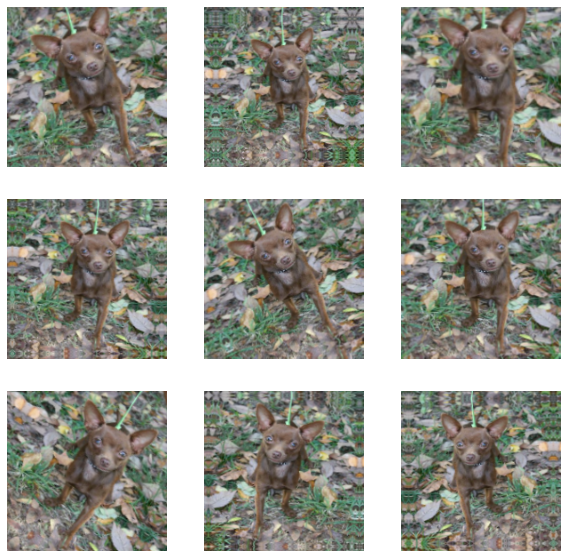

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(labels[0])
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

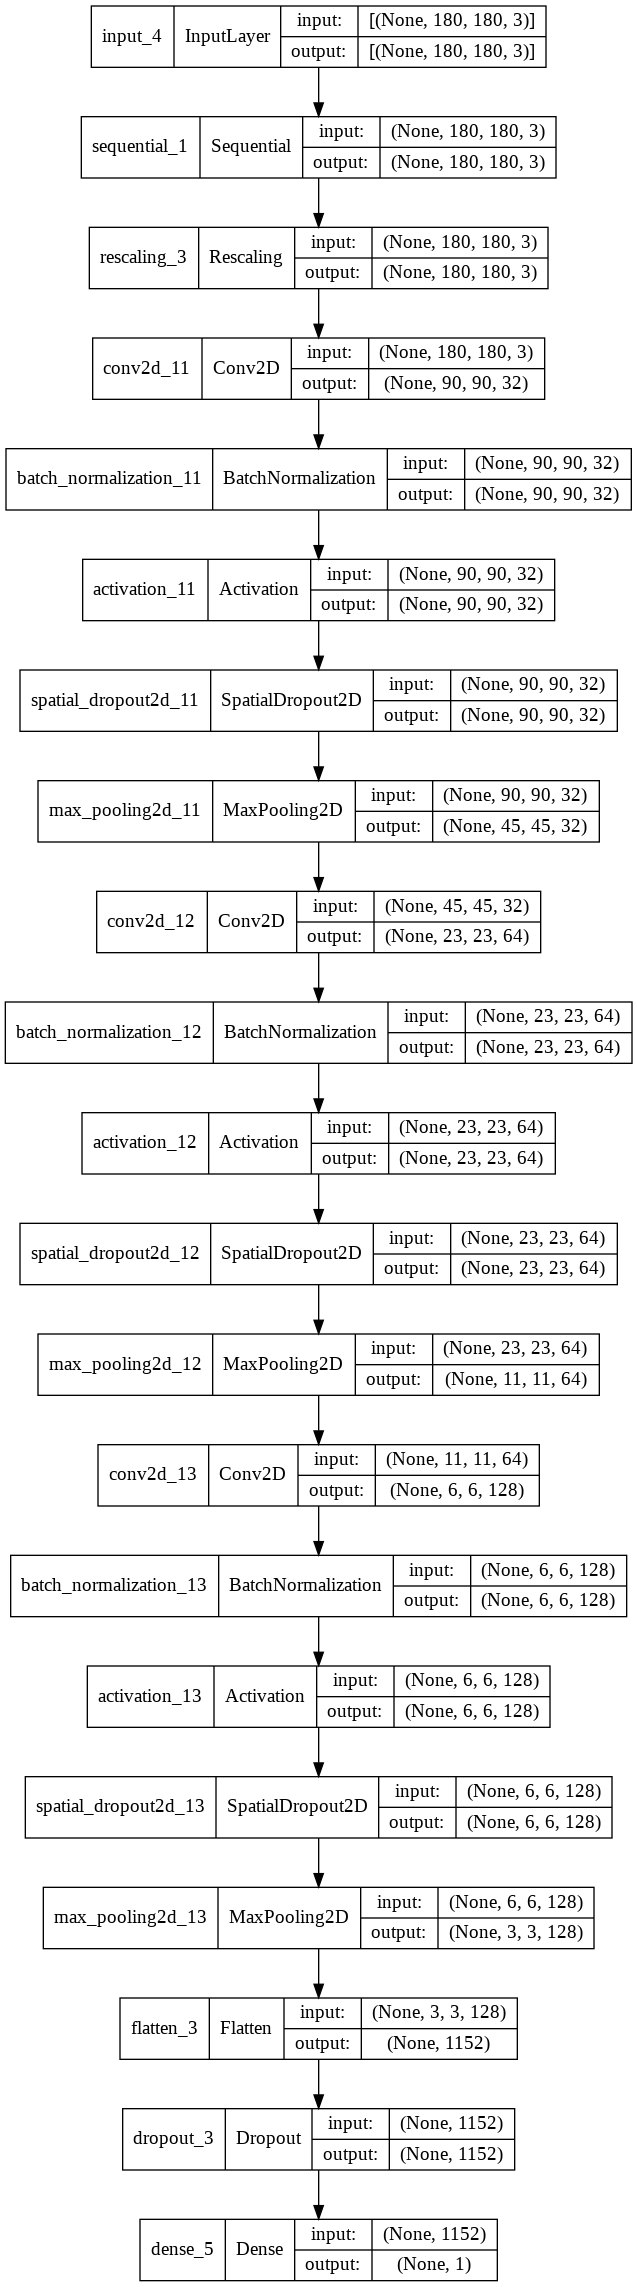

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x) 
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 5, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPooling2D()(x)

    # x = layers.Conv2D(256, 5, strides=2, padding="same")(x)
    # x = layers.BatchNormalization()(x)
    # x = layers.Activation("relu")(x)
    # x = layers.SpatialDropout2D(0.2)(x)
    # x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    # x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)


In [ ]:
# print(model.summary())

## Train the model


In [ ]:
epochs = 500

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5", save_best_only=True),
]
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/500
50/50 [==============================] - 14s 48ms/step - loss: 1.0482 - accuracy: 0.5269 - val_loss: 0.6937 - val_accuracy: 0.4700
Epoch 2/500
50/50 [==============================] - 4s 64ms/step - loss: 1.0056 - accuracy: 0.5263 - val_loss: 0.7027 - val_accuracy: 0.4650
Epoch 3/500
50/50 [==============================] - 3s 63ms/step - loss: 0.9500 - accuracy: 0.5650 - val_loss: 0.7328 - val_accuracy: 0.4650
Epoch 4/500
50/50 [==============================] - 3s 63ms/step - loss: 0.9301 - accuracy: 0.5638 - val_loss: 0.7704 - val_accuracy: 0.4650
Epoch 5/500
50/50 [==============================] - 3s 61ms/step - loss: 0.8766 - accuracy: 0.5831 - val_loss: 0.7729 - val_accuracy: 0.4650
Epoch 6/500
50/50 [==============================] - 3s 61ms/step - loss: 0.8920 - accuracy: 0.5781 - val_loss: 0.8193 - val_accuracy: 0.4650
Epoch 7/500
50/50 [==============================] - 3s 61ms/step - loss: 0.8398 - accuracy: 0.6137 - val_loss: 0.7447 - val_accuracy: 0.4950
Epoch

## Predict


In [ ]:
img = keras.preprocessing.image.load_img(
    "/content/data/train/cats/cat.0.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


This image is 94.47 percent cat and 5.53 percent dog.
